In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
import os
from sklearn.decomposition import PCA
import time
import random
from random import randint, sample
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns
import fastdtw

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [41]:
gau = pd.read_csv('./data/similarity/gaussian_LD.txt', sep='\t', index_col=None, header=None)
exp = pd.read_csv('./data/similarity/normalized_toni_exp.txt', sep='\t', index_col=0, header=0)
path = pd.read_csv('./data/similarity/toni_path.txt', sep='\t', index_col=0, header=0)
gene = pd.read_excel('./data/similarity/gene_LD_final.xlsx', sheet_name = 'Sheet2', header=0,index_col=0)
tf = pd.read_excel('./data/similarity/tf_ld_final.xlsx',sheet_name = 'Sheet2', header=0,index_col=0)
seq = pd.read_csv('./data/similarity/sequence_LD.txt', sep='\t', index_col=0, header=0)

#### 根据数据分布，选取阈值，生成邻接矩阵

In [44]:
def threshold(mir):
    a = list(np.array(mir.values).flatten())
    kde_norm = sns.kdeplot(a,label='auto') 
    x_vals = kde_norm.get_lines()[0].get_data()[0]
    y_vals = kde_norm.get_lines()[0].get_data()[1]
    cdf = np.cumsum(y_vals) / np.sum(y_vals)
    position_33 = x_vals[np.argmax(cdf >= 0.33)]
    position_50 = x_vals[np.argmax(cdf >= 0.50)]
   
    print(f'33: {position_33}; 50: {position_50}')
    return 0

33: 0.14315666484926773; 50: 0.2667879203345608


0

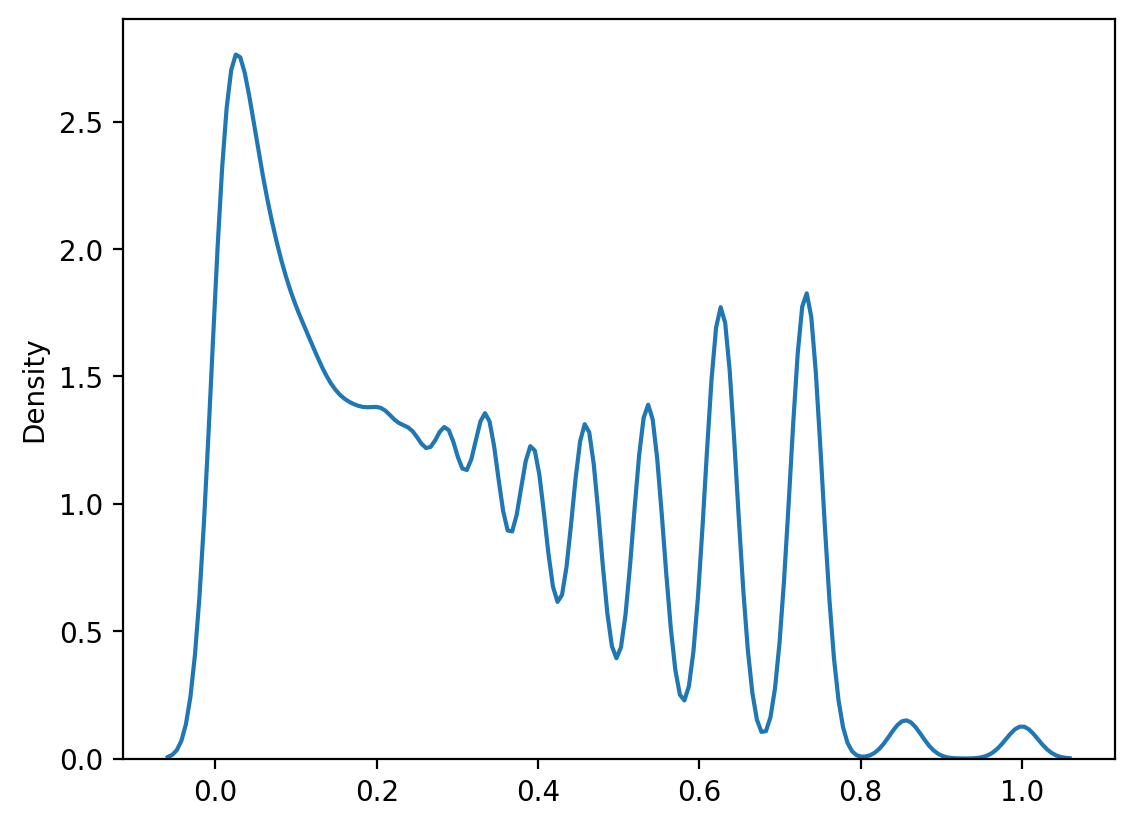

In [45]:
threshold(gau)

33: 0.49325434616540687; 50: 0.9080291753562298


0

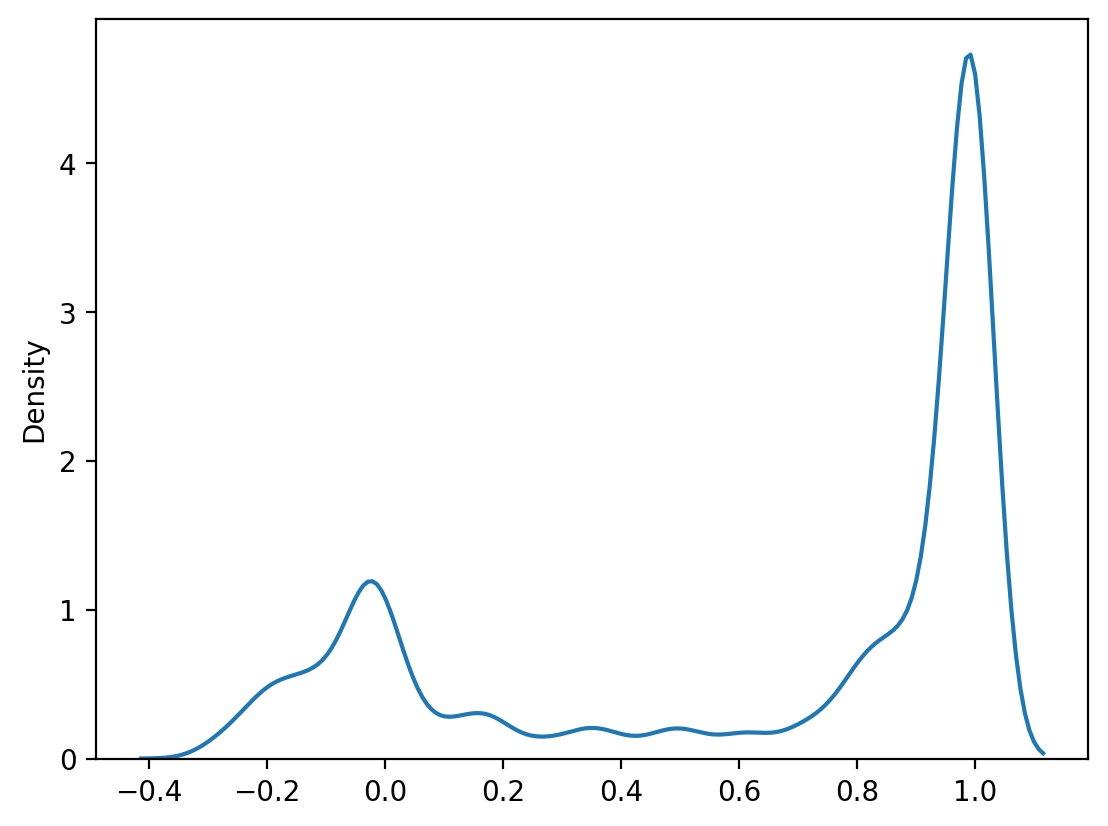

In [46]:
threshold(exp)

33: 0.5539221782228714; 50: 0.6460580221805525


0

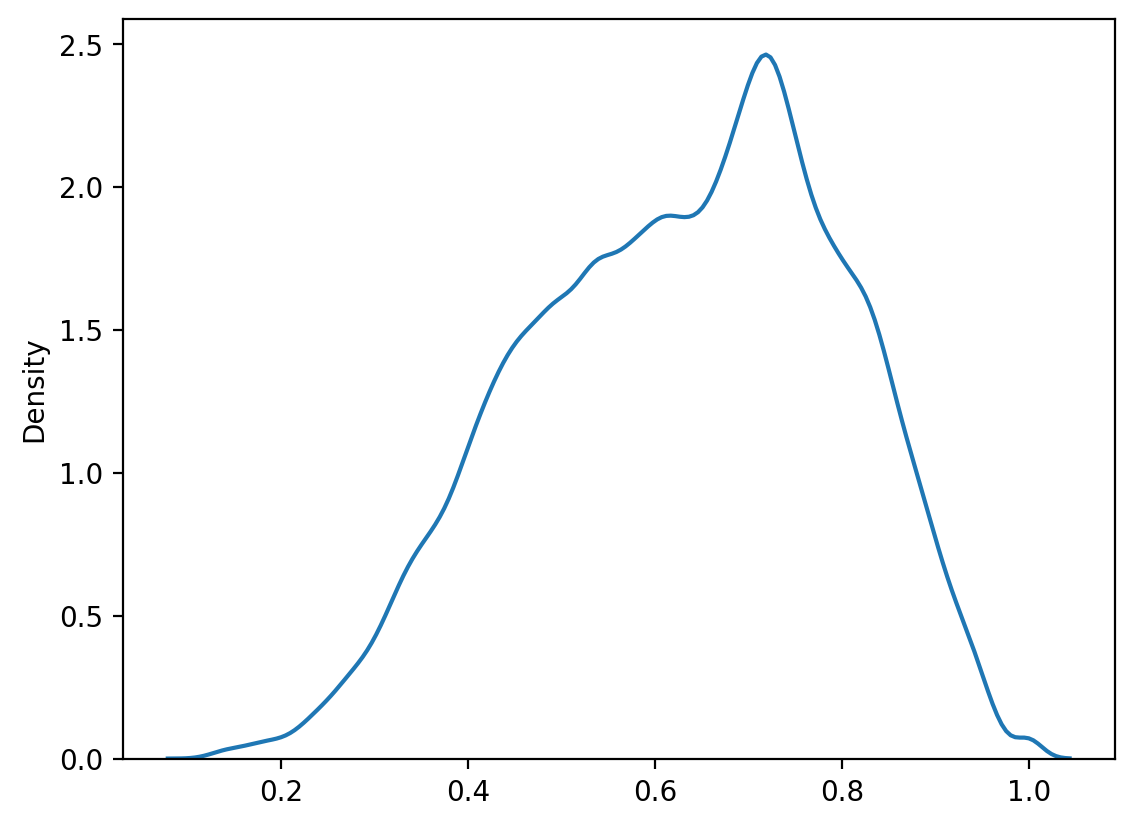

In [47]:
threshold(path)

33: 0.9374324251017203; 50: 0.951055725945427


0

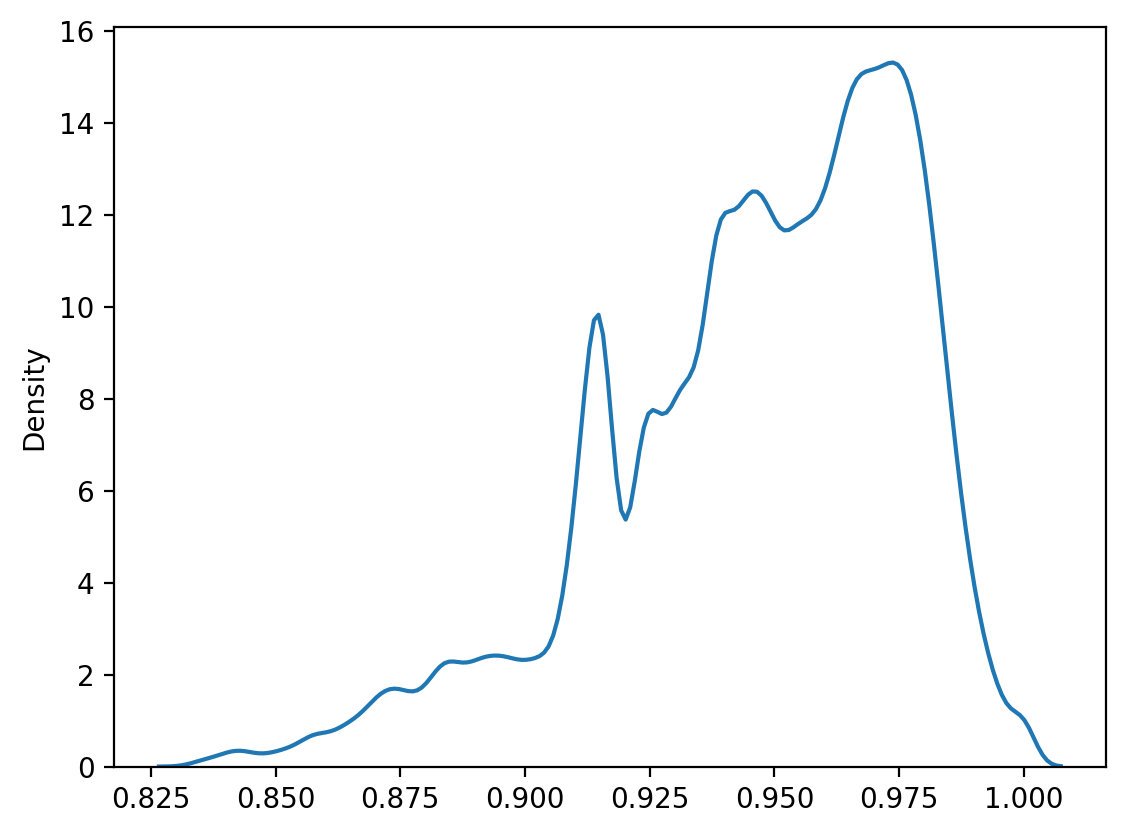

In [48]:
threshold(gene)

33: 0.9303960777901605; 50: 0.9461824214266835


0

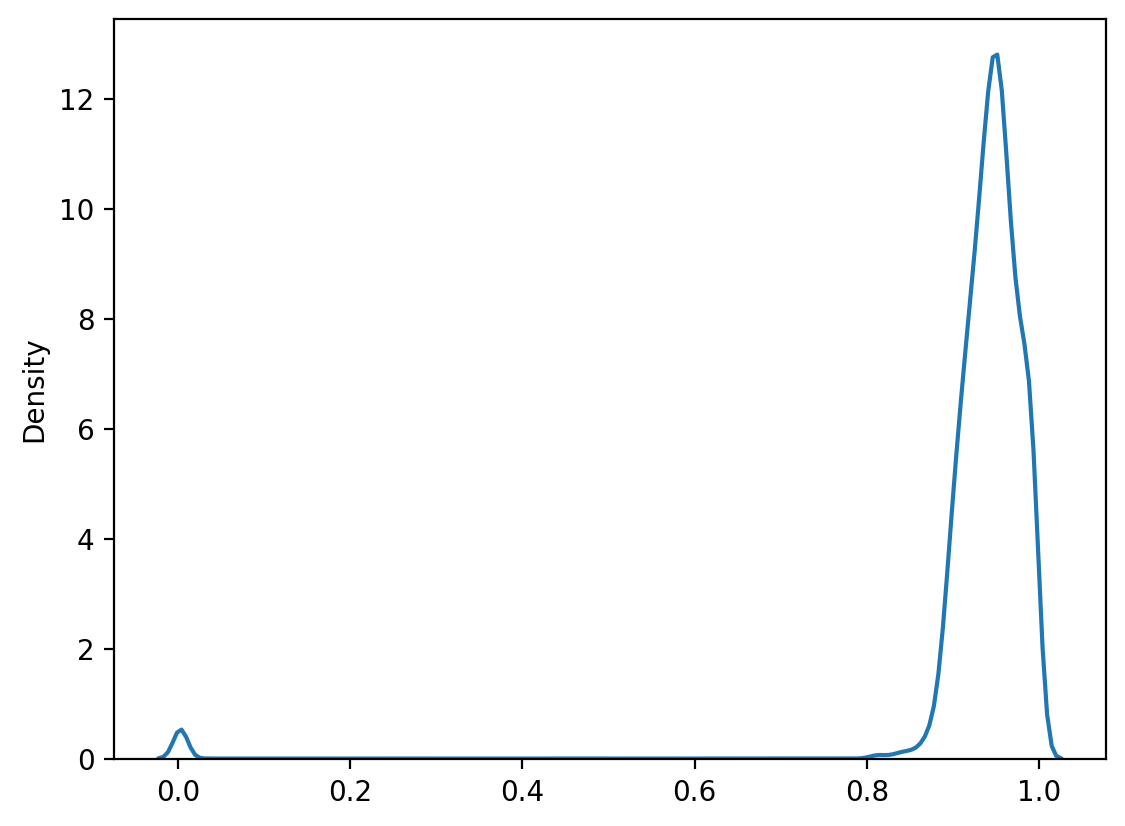

In [49]:
threshold(tf)

33: 0.6500278353068086; 50: 0.7049637749181112


0

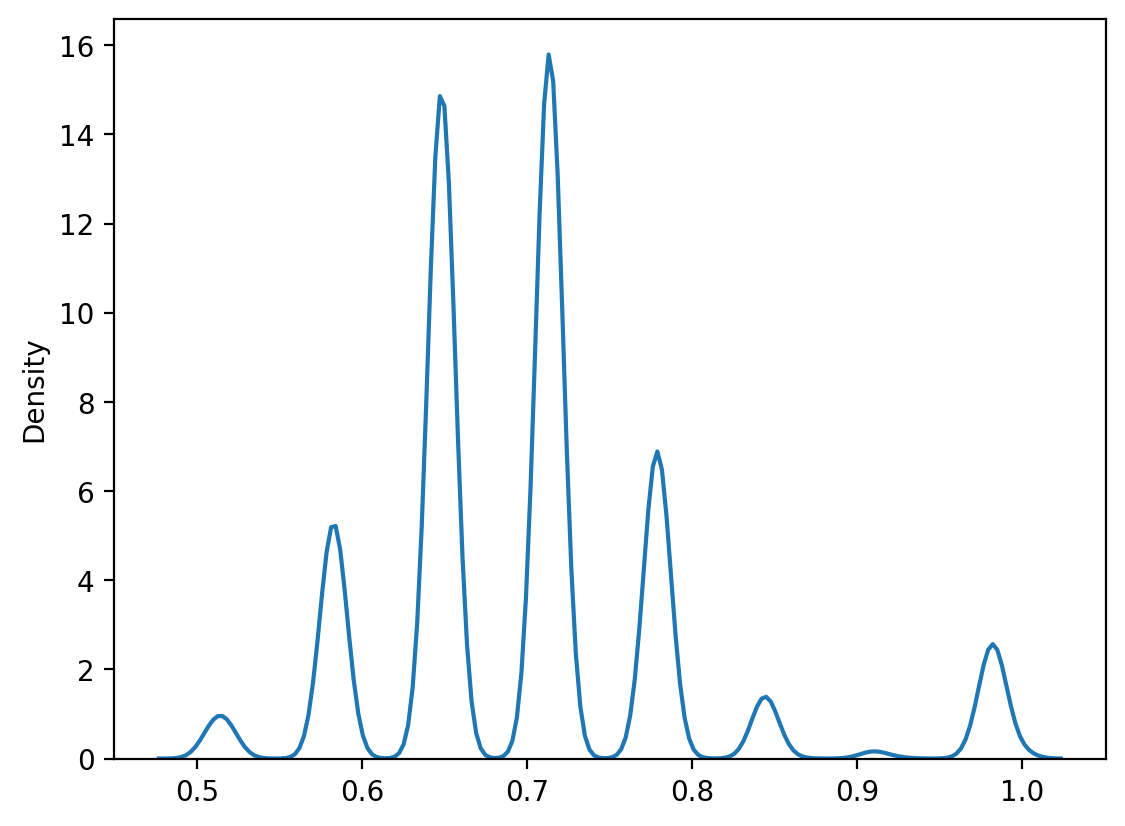

In [50]:
threshold(seq)

In [18]:
"""
    Cite from: Wu XB, Zhou Y: GE-Impute: graph embedding-based imputation for single-cell RNA-seq data. Brief Bioinform 2022, 23(5):bbac313.
"""

from ge.classify import read_node_label,Classifier
from ge import Node2Vec
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE

In [19]:
def graph_embedding(initialGraph):
    G = nx.from_pandas_adjacency(initialGraph)
    model = Node2Vec(G, walk_length = 5, num_walks = 20,p = 0.25, q = 4, workers = 1)#init model
    model.train(window_size = 3, iter = 3)
    embeddings = pd.DataFrame(model.get_embeddings())
    return embeddings

def imputation(embeddingfile,inigraph):
    prediction_distance=pairwise_distances(embeddingfile.T,n_jobs=5,metric="euclidean")
    adj_matrix_merge=np.array(inigraph)
    for j in range(adj_matrix_merge.shape[0]):
        adj_matrix_merge[np.argsort(prediction_distance[:,j])[0:np.sum(adj_matrix_merge[:,j]==1)],j]=1
        
    df_imputation=pd.DataFrame(adj_matrix_merge)
    df_imputation.columns=embeddingfile.columns.tolist()
    df_imputation.index=embeddingfile.columns.tolist()
    return df_imputation

In [52]:
exp[exp.values >=0.91] = 1
exp[exp.values < 0.91] = 0
exp = exp.fillna(0)
embeddings_df=graph_embedding(exp) #inig 初始网络
result=imputation(embeddings_df,exp) #预测网络
result.to_csv("./network/ie_toni_exp.txt", header= None,sep = '\t',index=None)

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Learning embedding vectors...
Learning embedding vectors done!


In [53]:
path[path.values >=0.91] = 1
path[path.values < 0.91] = 0
path = path.fillna(0)
embeddings_df=graph_embedding(path) #inig 初始网络
result=imputation(embeddings_df,path) #预测网络
result.to_csv("./network/ie_toni_path.txt", header= None,sep = '\t',index=None)

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Learning embedding vectors...
Learning embedding vectors done!


In [54]:
gene.values[gene.values >=0.97] = 1
gene.values[gene.values < 0.97] = 0
gene = gene.fillna(0)
embeddings_df=graph_embedding(gene) #inig 初始网络
result=imputation(embeddings_df,gene) #预测网络
result.to_csv("./network/ie_ld_gene_0.97.txt", header= None,sep = '\t',index=None)

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Learning embedding vectors...
Learning embedding vectors done!


In [55]:
tf.values[tf.values >=0.95] = 1
tf.values[tf.values < 0.95] = 0
tf = tf.fillna(0)
embeddings_df=graph_embedding(tf) #inig 初始网络
result=imputation(embeddings_df,tf) #预测网络
result.to_csv("./network/ie_ld_tf_0.95.txt", header= None,sep = '\t',index=None)

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Learning embedding vectors...
Learning embedding vectors done!


In [56]:
gau.values[gau.values >=0.3] = 1
gau.values[gau.values < 0.3] = 0
embeddings_df=graph_embedding(gau) #inig 初始网络
result=imputation(embeddings_df,gau) #预测网络
result.to_csv("./network/gau.txt", header= None,sep = '\t',index=None)

seq.values[seq.values >=0.75] = 1
seq.values[seq.values < 0.75] = 0
embeddings_df=graph_embedding(seq) #inig 初始网络
result=imputation(embeddings_df,seq) #预测网络
result.to_csv("./network/seq.txt", header= None,sep = '\t',index=None)


Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Learning embedding vectors...
Learning embedding vectors done!
Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Learning embedding vectors...
Learning embedding vectors done!


#### Substitute the filled miRNA network into ie_ L1norm R. Obtain the prediction result matrix after semi supervised learning